<a href="https://colab.research.google.com/github/mohamed32145/MindCare/blob/main/fslDataproccessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

"""
 ADNI1 MRI Image Preprocessing Overview

The ADNI1 MRI images undergo several preprocessing steps before being made publicly available.
 This documentation outlines additional steps applied during our project for organizing and preparing these images for analysis.

---

 Image Folder Naming Convention & Preprocessing Status

ADNI folders named:

* `MPR-R__GradWarp__B1_Correction__N3__Scaled`
* `MPR__GradWarp__B1_Correction__N3__Scaled`

indicate that the following preprocessing has already been performed by ADNI:

GradWarp**: Corrects for gradient non-linearity (geometric distortion).
B1 Correction**: Corrects for B1 field inhomogeneity (ensures uniform intensity).
N3 Bias Field Correction**: Removes low-frequency intensity non-uniformities.
Scaling**: Normalizes image intensity across different scans.

---

 Project-Specific Preprocessing Steps

 For **AD** and **CN** groups:

Select only images from folders:

* `MPR-R__GradWarp__B1_Correction__N3__Scaled` or
* `MPR__GradWarp__B1_Correction__N3__Scaled`

Perform the following preprocessing steps:

1.  Skull Stripping

   * Tool: [FSL BET](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET)

2. Resampling to Common Voxel Size (e.g., 1×1×1 mm³)

   * Tool: [`nibabel`](https://nipy.org/nibabel/) + `scipy.ndimage`

3. Reshaping to Consistent Dimensions

   * Shape: `128 × 128 × 128`

---

 For pMCI and sMCI groups:

If the folder name contains:

* `MPR-R__GradWarp__B1_Correction__N3__Scaled` or
* `MPR__GradWarp__B1_Correction__N3__Scaled`

Apply **the same preprocessing steps as AD/CN**.

 If the folder name is:

* `MPR__GradWarp__N3__Scaled` (i.e., missing B1 Correction)

Apply the following steps:

1. N4 Bias Field Correction

   * Tool: [ANTs N4BiasFieldCorrection](https://github.com/ANTsX/ANTs) or [SimpleITK](https://simpleitk.readthedocs.io/)

2. Then apply all AD/CN preprocessing steps:

   * Skull stripping (FSL BET)
   * Resampling
   * Reshaping

---

 Tools Used

| Task                     | Tool/Library     |
| ------------------------ | ---------------- |
| Skull Stripping          | FSL BET          |
| Bias Field Correction    | SimpleITK / ANTs |
| Resampling               | nibabel, scipy   |
| Reshaping to uniform dim | numpy            |

"""


In [ ]:
import os
import numpy as np
import nibabel as nib
import SimpleITK as sitk
from pathlib import Path
from subprocess import run
import subprocess
from scipy.ndimage import zoom
import tempfile

# Your existing configuration
TARGET_VOXEL_SIZE = (1.0, 1.0, 1.0)
TARGET_SHAPE = (128, 128, 128)

# Your existing functions
import subprocess
from pathlib import Path


"""
the skull extraction will be done via wsl commands



#!/bin/bash

# === Set up FSL environment ===
export FSLDIR=/home/moham/fsl
source $FSLDIR/etc/fslconf/fsl.sh
export FSLOUTPUTTYPE=NIFTI_GZ

# === Input and output directories ===
INPUT_DIR="/mnt/c/Users/moham/OneDrive/Desktop/study/now/master/DSLab/images"
OUTPUT_DIR="/mnt/c/Users/moham/OneDrive/Desktop/study/now/master/DSLab/skull_stripped"

mkdir -p "$OUTPUT_DIR"

# === Loop over all NIfTI files ===
for img in "$INPUT_DIR"/*.nii; do
    base=$(basename "$img" .nii)
    output="$OUTPUT_DIR/${base}_skullstripped.nii.gz"

    echo " Processing $base ..."
    bet "$img" "$output" -R -f 0.5 -g 0
done

echo " Skull stripping completed for all images."


"""




def resample_image(image, target_voxel_size):
    current_affine = image.affine
    current_header = image.header
    current_voxel_size = current_header.get_zooms()[:3]
    zoom_factors = [c / t for c, t in zip(current_voxel_size, target_voxel_size)]
    resampled_data = zoom(image.get_fdata(), zoom_factors, order=1)
    new_affine = np.copy(current_affine)
    for i in range(3):
        new_affine[i, i] *= target_voxel_size[i] / current_voxel_size[i]
    return nib.Nifti1Image(resampled_data, new_affine)

def reshape_to_target(image, target_shape):
    data = image.get_fdata()
    pad_width = [(0, max(0, target - s)) for s, target in zip(data.shape, target_shape)]
    padded = np.pad(data, pad_width, mode='constant', constant_values=0)
    cropped = padded[:target_shape[0], :target_shape[1], :target_shape[2]]
    return nib.Nifti1Image(cropped, image.affine)

def n4_bias_correction(input_image):
    sitk_image = sitk.GetImageFromArray(input_image.get_fdata())
    sitk_image = sitk.Cast(sitk_image, sitk.sitkFloat32)
    mask_image = sitk.OtsuThreshold(sitk_image, 0, 1, 200)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected_image = corrector.Execute(sitk_image, mask_image)
    corrected_array = sitk.GetArrayFromImage(corrected_image)
    return nib.Nifti1Image(corrected_array, input_image.affine)

def process_single_image(input_path, group="AD", output_dir=None):
    """
    Process a single image through the preprocessing pipeline

    Args:
        input_path (str): Path to input NIfTI image
        group (str): Group label ("AD", "CN", "pMCI", "sMCI") - affects bias correction
        output_dir (str): Output directory (if None, uses same directory as input)
    """

    input_path = Path(input_path)
    base = input_path.stem.replace(".nii", "")

    if output_dir is None:
        output_dir = input_path.parent / "preprocessed"
    else:
        output_dir = Path(output_dir)

    output_dir.mkdir(parents=True, exist_ok=True)

    print(f"Processing: {input_path}")
    print(f"Group: {group}")
    print(f"Output directory: {output_dir}")

    try:
        # Load original image to check properties
        image = nib.load(input_path)
        print(f" shape: {image.shape}")
        print(f" voxel size: {image.header.get_zooms()[:3]}")


        # 3. Optional bias correction for pMCI/sMCI with N3 only
        if group in ["pMCI", "sMCI"] and "N3__Scaled" in str(input_path) and "B1_Correction" not in str(input_path):
            print("Step 3: Applying N4 bias correction...")
            image = n4_bias_correction(image)
        else:
            print("Step 3: Skipping bias correction (not needed for this group/image type)")

        # 4. Resample
        print("Step 4: Resampling...")
        image = resample_image(image, TARGET_VOXEL_SIZE)
        print(f"After resampling shape: {image.shape}")

        # 5. Reshape
        print("Step 5: Reshaping to target dimensions...")
        image = reshape_to_target(image, TARGET_SHAPE)
        print(f"Final shape: {image.shape}")

        # 6. Save final image
        final_output = output_dir / f"{base}_preprocessed.nii"
        nib.save(image, final_output)

        print(f"✅ Successfully processed: {input_path} ➜ {final_output}")

        return final_output

    except Exception as e:
        print(f"❌ Error processing {input_path}: {str(e)}")
        return None

# Example usage
if __name__ == "__main__":
    # Replace with your actual image path
    test_image_path = r"C:\Users\moham\OneDrive\Desktop\study\now\master\DSLab\skull_stripped\image_skullstripped.nii.gz"


    # Test with different groups
    output_path = process_single_image(
        input_path=test_image_path,
        group="AD",  # Change to "CN", "pMCI", "sMCI" as needed
        output_dir=r"C:\Users\moham\OneDrive\Desktop\study\now\master\DSLab\skull_stripped"
    )

    if output_path:
        print(f"\nFinal processed image saved at: {output_path}")

        # Load and inspect the final result
        final_image = nib.load(output_path)
        print(f"Final image shape: {final_image.shape}")
        print(f"Final voxel size: {final_image.header.get_zooms()[:3]}")
        print(f"Data range: {final_image.get_fdata().min():.2f} to {final_image.get_fdata().max():.2f}")

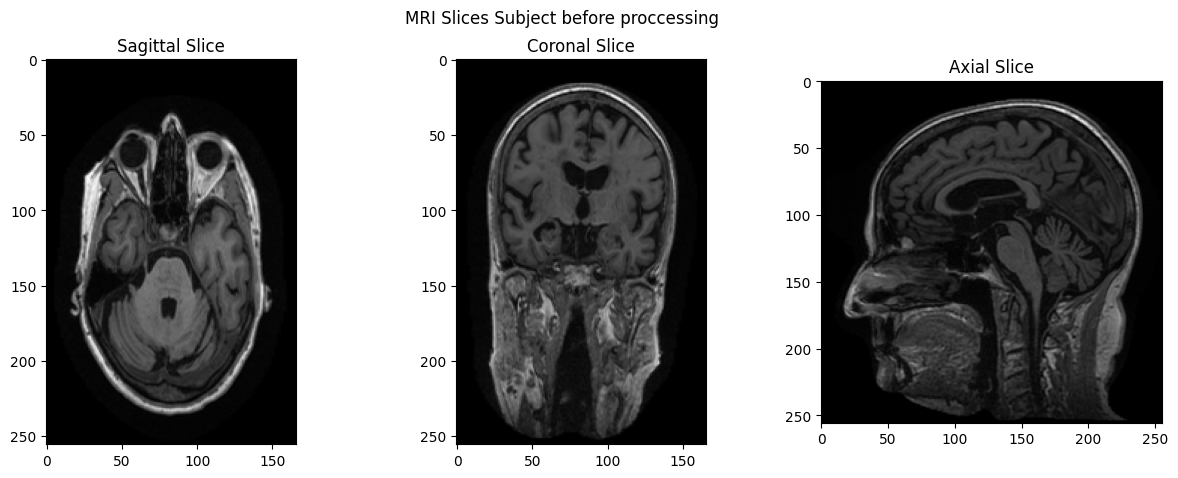

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load a NIfTI image
img_path = r"image.nii"
img = nib.load(img_path)
img_data = img.get_fdata()
# Plot middle slice in all 3 dimensions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_data[img_data.shape[0]//2, :, :], cmap='gray')
plt.title('Sagittal Slice')

plt.subplot(1, 3, 2)
plt.imshow(img_data[:, img_data.shape[1]//2, :], cmap='gray')
plt.title('Coronal Slice')

plt.subplot(1, 3, 3)
plt.imshow(img_data[:, :, img_data.shape[2]//2], cmap='gray')
plt.title('Axial Slice')

plt.suptitle('MRI Slices Subject before proccessing')
plt.show()

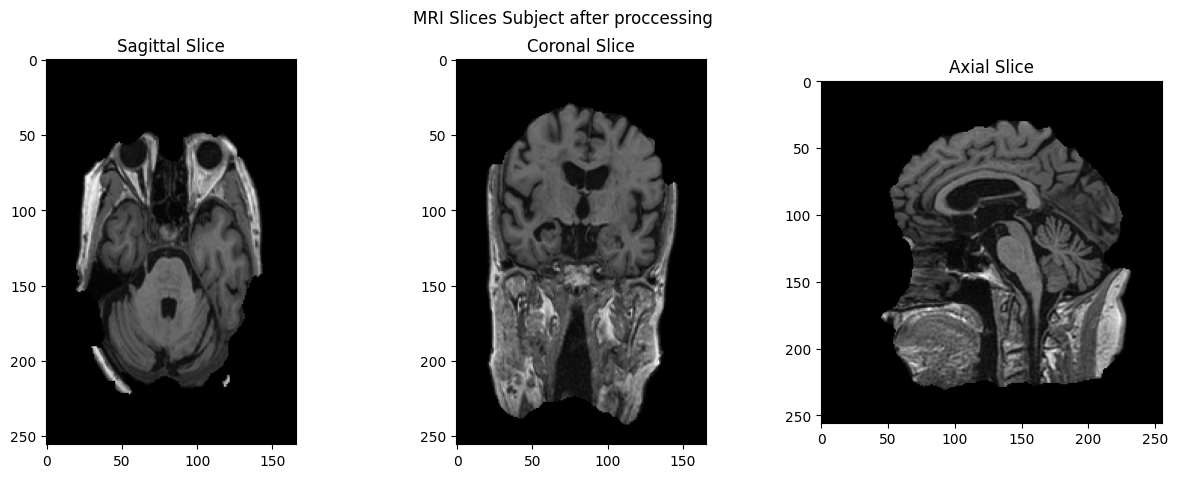

In [2]:
img_path = r"image_skullstripped.nii.gz"
img = nib.load(img_path)
img_data = img.get_fdata()
# Plot middle slice in all 3 dimensions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_data[img_data.shape[0]//2, :, :], cmap='gray')
plt.title('Sagittal Slice')

plt.subplot(1, 3, 2)
plt.imshow(img_data[:, img_data.shape[1]//2, :], cmap='gray')
plt.title('Coronal Slice')

plt.subplot(1, 3, 3)
plt.imshow(img_data[:, :, img_data.shape[2]//2], cmap='gray')
plt.title('Axial Slice')

plt.suptitle('MRI Slices Subject after partial proccessing')
plt.show()